## Домашнее задание 5

Стребежев Игорь

In [1]:
%%html
<style>video{width:480px;height:480px}</style>

In [433]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib as mpl
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import normalize
from scipy.special import expit
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 8, 8

В задачах 2, 3, 5 градиентный спуск нужно делать пока уменьшается ошибка на датасете.

### task 1

Обратное распространение градиента. Напоминание — для последнего слоя нейронной сети $\delta$ выражается как:

$$ \delta^L_i = \frac{\partial L(w)}{ \partial s^L_i } $$ 

Выпишите в явном виде $\delta^L$ для softmax в качестве решающей функциии и кросс-энтропией в качестве функции потерь.

### task 2

Реализуйте алгоритм логистической регрессии со стохастическим градиентным спуском.

In [341]:
df = pd.read_csv(f'spambase_old.csv')
X = df.drop('label', 1).as_matrix()
Y = df.label.map({0: -1, 1: 1}).values


def logistic_train(X, Y, iters=100_000, W = None):
    rate = 0.1  # learning rate
    W = np.random.randn(X.shape[1]) if W is None else W.copy()
    ebest = ((Y * X.dot(W)) < 0).sum()
    wbest = W
    print(ebest, end=' ')
    limit = iters

    while limit > 0:
        limit -= 1
        i = np.random.randint(0, Y.size - 1)  # grub a random sample
        k =  expit(-Y[i] * X[i].dot(W))       # nominator, slide 10
        W += rate * (Y[i] * X[i] * k)         # update weights
        err = ((Y * X.dot(W)) < 0).sum()
        if err < ebest:                       # continue if err gets smaller
            ebest = err
            wbest = W.copy()
            limit = iters
            print(err, end=' ')
            
    print('done')
    return wbest

Обучите его на датасете `spambase_old` (train).

In [409]:
# W = logistic_train(X, Y, W=None)

W = np.array([-4.44334964e+02, -3.42531850e+02, -2.59445328e+02,  1.47926305e+03,        8.01327295e+02,  9.48710085e+02,  3.54677988e+03,  1.55324713e+03,        8.52344457e+02,  4.62304134e+01,  2.53977249e+02, -1.99480324e+03,       -2.10349452e+02, -1.78907298e+02,  2.20554361e+03,  1.78486153e+03,        2.70404100e+03, -9.98807026e+00, -2.19596583e+02,  3.16341622e+03,        1.53405576e+02,  5.93403648e+02,  4.52461243e+03,  1.97909298e+03,       -1.55504208e+04, -7.38900604e+03, -6.31801206e+03, -5.52413052e+02,       -2.18192166e+03, -2.09907823e+03, -1.74741245e+03, -6.88698738e+02,       -5.74739246e+03, -7.32442591e+02, -3.08376105e+03, -1.20939912e+03,       -5.16668985e+03, -1.01287885e+03, -1.95237694e+03, -1.86733959e+03,       -1.75491030e+03, -4.15031608e+03, -1.53133437e+03, -3.02086366e+03,       -3.41890464e+03, -7.17348494e+03, -5.11303945e+02, -2.20498781e+03,       -3.47624322e+03, -3.45943548e+03, -1.03761182e+03,  7.35362845e+02,        4.12547774e+03,  1.07555641e+03, -1.73644270e+02,  6.64030930e+01,         2.03363500e-01])

И проверьте на датасете `spambase_new` (val). Получите ROC кривые для вариантов без нормировки и с нормировкой признаков.

# accuracy
train        0.9201086956521739   auc 0.9614971010117431
train norm   0.9019021739130435   auc 0.9552538646725963
val          0.9196525515743756   auc 0.9610228791571663
val norm     0.9153094462540716   auc 0.9579418586366854


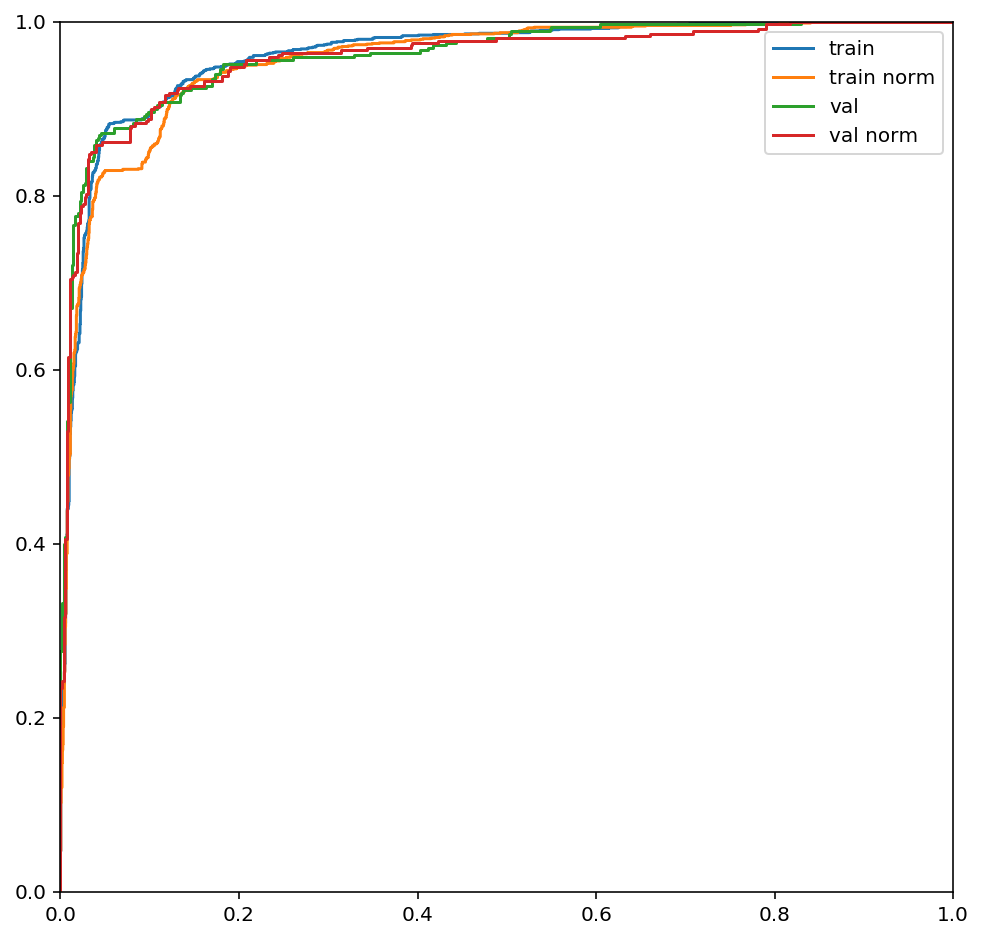

In [411]:
df2 = pd.read_csv(f'spambase_new.csv')
X2 = df2.drop('label', 1).as_matrix()
Y2 = df2.label.map({0: -1, 1: 1}).values


def res(Y, X, name):
    print(name.ljust(12), 1 - ((Y * X.dot(W)) < 0).sum() / Y.size,
         '  auc', roc_auc_score(Y > 0, X.dot(W)))
    fpr, tpr, _ = roc_curve(Y > 0, X.dot(W))
    plt.plot(fpr, tpr, label=name)
    plt.xlim([0, 1]); plt.ylim([0, 1]); plt.legend()


print('# accuracy')
res(Y, X, 'train')
res(Y, normalize(X, axis=0), 'train norm')
res(Y2, X2, 'val')
res(Y2, normalize(X2, axis=0), 'val norm')

### task 3

Модифицируйте модель из задачи 2, добавив 2 скрытых слоя (по 64 нейрона) с функциями активации ReLU в них и реализовав алгоритм обратного распространения градиента.

### task 4

Разделите датасет `mnist.csv` на train(80%), val(10%), test(10%) с сохранением пропорций классов. Убедитесь, что пропорции сохранились.

In [478]:
dm = pd.read_csv('mnist.csv').sample(frac=1).reset_index(drop=True)

gen = lambda: pd.DataFrame(columns=dm.columns)
trainM, valM, testM = gen(), gen(), gen()

for num in range(0, 11):
    sub = dm[dm.label == num]
    total = sub.shape[0]
    i80, i90 = int(total * 0.8), int(total * 0.9)
    
    trainM = trainM.append(sub[:i80])
    testM  = testM.append(sub[i80:i90])
    valM   = valM.append(sub[i90:])
    
# Убеждаемся
count = lambda df: df.label.value_counts() / df.shape[0]
pd.concat([count(dm), count(trainM), count(valM), count(testM)], axis=1)

,label,label,label,label
0,0.0980,0.098037,0.097610,0.098098
1,0.1135,0.113543,0.113546,0.113113
2,0.1032,0.103164,0.103586,0.103103
3,0.1010,0.101038,0.100598,0.101101
4,0.0982,0.098162,0.098606,0.098098
5,0.0892,0.089158,0.089641,0.089089
6,0.0958,0.095786,0.095618,0.096096
7,0.1028,0.102789,0.102590,0.103103
8,0.0974,0.097412,0.097610,0.097097
9,0.1009,0.100913,0.100598,0.101101


### task 5

Модифицируйте модель из задачи 3, заменив последний нейрон на 10 нейронов, и реализовав мультиклассовую классификацию с softmax в качестве решающей функции и кросс-энтропией в качестве функции потерь.

### task 6

Решите задачу 5 с помощью kNN, дерева и случайных лесов(проведя разумный подбор параметров по val датасету). Сравните результатына test датасете.